In [8]:
import os
import matplotlib.pyplot as plt
from matplotlib import colormaps
from src.models.NSI import NSI
from src.models.channel import *
from src.models.continuous_models import *
from tqdm.notebook import tqdm
import pickle
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from scipy import stats
from scipy.interpolate import interp1d
from collections import defaultdict
import numpy as np
import networkx as nx
import matplotlib

In [9]:

N = 10000
T = 1000
beta = 0.01
k = 4
num_runs = 100


In [97]:
## Errors

lin_errors = np.linspace(0,1,21)
log_errors = np.logspace(-10,0,11)
all_errors = np.concatenate([lin_errors, log_errors])
all_errors = np.unique(all_errors)

G = nx.barabasi_albert_graph(n=24, m=2)
M = nx.adjacency_matrix(G).todense()

channel_mapping = {
    
    'bin_sym': {err: single_flip_channel(1, err) for err in all_errors},
    'triangle': {err: simplex_channel(3, err) for err in all_errors},
    'cherry': {err: star_channel(3, err) for err in all_errors},
    'paw': {err: paw_channel(err) for err in all_errors},
    'bin_asym': {err: bin_asym_channel(0.1, (0.1 - err) % 1) for err in all_errors}
    'bin_asym_var': {err: bin_asym_channel(err, (err - 0.1 )% 1) for err in all_errors}
    
}


"""
channel_mapping = {'bin_sym': {err: single_flip_channel(1, err) for err in [0.1, 0.65]},
                  'triangle': {err: simplex_channel(3, err) for err in [0.1, 0.65]}}

"""
num_errors = len(all_errors)
num_channels = len(channel_mapping.keys())

colors = ['crimson', 'lightsteelblue', 'moccasin', 'lightgreen']


In [131]:
#num_errors = 2
#num_channels = 2

mean_gillespie_results = {
    
    'bin_sym': {err: [] for err in all_errors},
    'triangle': {err: [] for err in all_errors},
    'cherry': {err: [] for err in all_errors},
    'paw': {err: [] for err in all_errors},
    'bin_asym': {err: [] for err in all_errors}
    
}

mean_field_results = {
    
    'bin_sym': {err: [] for err in all_errors},
    'triangle': {err: [] for err in all_errors},
    'cherry': {err: [] for err in all_errors},
    'paw': {err: [] for err in all_errors},
    'bin_asym': {err: [] for err in all_errors}
    
}


fig, axs = plt.subplots(num_errors, num_channels, figsize=(8.5,33))

channel_idx = 0
for name,channel_dict in channel_mapping.items():
    
    error_idx = 0
    for err, channel in channel_dict.items():
        
        alphabet_size = channel.shape[0]
        
        # Initial state always set to 1 observer encoding message 0
        initial_state = np.array([1] + [0]*(alphabet_size-1)) 
    
        # Noisy Gillespie Algorithm
        runs = list()
        for _ in tqdm(range(num_runs)):
            
            sim = NoisyGillespie(N=N, initial_state=initial_state, beta=beta, k=k, 
                                channel=channel)
            test_sim = sim.simulate(max_time=T, density=True)
            runs.append((test_sim[0], test_sim[1]))
                                     
        # Interpolating Gillespie Means
        common_time = np.linspace(0, T, T+1)
        interpolated_values = []
        
        for run_t, run_y in runs:
            interp_func = interp1d(run_t, run_y, kind='linear', fill_value='extrapolate', axis=0) 
            interpolated_values.append(interp_func(common_time))
        
        interp_sim_arr = np.array(interpolated_values)
        
        sim_means = np.mean(interp_sim_arr, axis=0)

        sim_se = np.std(interp_sim_arr, axis=0) / np.sqrt(num_runs)
        conf_int = 1.96 * sim_se

        sim_lower = sim_means - conf_int
        sim_higher = sim_means + conf_int

        sim_lower = np.clip(sim_lower, 0, 1)
        sim_higher = np.clip(sim_higher, 0, 1)
        
        # Mean-Field
        mean_field = ODE(beta=beta, k=k, channel=channel, T=T)
        analytic_curve = mean_field(initial_state=initial_state/N)


        for dim in range(sim_means.shape[1]):
            axs[error_idx, channel_idx].plot(common_time, sim_means[:, dim], color=colors[dim])
            axs[error_idx, channel_idx].fill_between(common_time, sim_means[:, dim], sim_lower[:, dim], 
                                                     alpha=0.6, color=colors[dim])
            axs[error_idx, channel_idx].fill_between(common_time, sim_means[:, dim], sim_higher[:, dim], 
                                                     alpha=0.6, color=colors[dim])
            axs[error_idx, channel_idx].plot(analytic_curve.t, analytic_curve.y.T, linestyle='dotted', alpha=0.6, 
                                            color='black', markersize=4)
            
        mean_gillespie_results[name][err].append((common_time, sim_means, sim_lower, sim_higher))
        mean_field_results[name][err].append((analytic_curve.t, analytic_curve.y.T))
            
        axs[error_idx, channel_idx].set_ylim(0, 1.05)
        

        if error_idx==0:
            axs[error_idx, channel_idx].set_title(name)

        if channel_idx==0:
            axs[error_idx, channel_idx].set_ylabel(f"{float(err):.3}")   

        if channel_idx==num_channels-1:
            axs[error_idx, channel_idx].yaxis.tick_right()
            axs[error_idx, channel_idx].yaxis.set_label_position("right")
            axs[error_idx, channel_idx].set_yticks(np.linspace(0,1,6))
        else:
            axs[error_idx, channel_idx].set_yticks([])

        axs[error_idx, channel_idx].set_xticks([]) 
            
        
        # Only show axes until the end of the average simulation
            
        error_idx += 1

    channel_idx += 1
    
    
plt.tight_layout()
plt.show()

#fig.savefig('/home/sagar/modeling-info-spread/reports/figures/full_continuous_phi_plots_2.pdf')

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [113]:
abridged_errors = all_errors[(all_errors < 0.3) & (all_errors > 1e-3)]

In [125]:
abridged_errors

array([0.01, 0.05, 0.1 , 0.15, 0.2 , 0.25])

In [126]:
abridged_errors.size

6

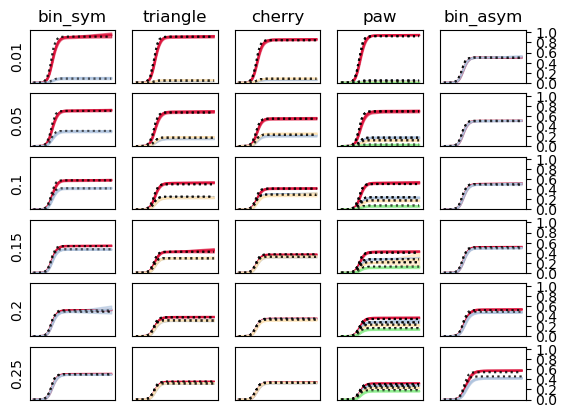

In [133]:
fig, axs = plt.subplots(abridged_errors.size, len(mean_gillespie_results.keys()))

channel_idx = 0
for name, sim_dict in mean_gillespie_results.items():
    
    analytical_dict = mean_field_results.get(name)
    
    error_idx = 0
    for err in abridged_errors:
        
        common_time, sim_means, sim_lower, sim_higher = sim_dict.get(err)[0]
        analytic_time, analytic_curve = analytical_dict.get(err)[0]
        
        for dim in range(sim_means.shape[1]):
            axs[error_idx, channel_idx].plot(common_time, sim_means[:, dim], color=colors[dim])
            axs[error_idx, channel_idx].fill_between(common_time, sim_means[:, dim], sim_lower[:, dim], 
                                                     alpha=0.6, color=colors[dim])
            axs[error_idx, channel_idx].fill_between(common_time, sim_means[:, dim], sim_higher[:, dim], 
                                                     alpha=0.6, color=colors[dim])
            axs[error_idx, channel_idx].plot(analytic_time, analytic_curve, linestyle='dotted', alpha=0.6, 
                                            color='black', markersize=4)
            
        axs[error_idx, channel_idx].set_ylim(0, 1.05)
        

        if error_idx==0:
            axs[error_idx, channel_idx].set_title(name)

        if channel_idx==0:
            axs[error_idx, channel_idx].set_ylabel(f"{float(err):.3}")   

        if channel_idx==num_channels-1:
            axs[error_idx, channel_idx].yaxis.tick_right()
            axs[error_idx, channel_idx].yaxis.set_label_position("right")
            axs[error_idx, channel_idx].set_yticks(np.linspace(0,1,6))
        else:
            axs[error_idx, channel_idx].set_yticks([])

        axs[error_idx, channel_idx].set_xticks([]) 
        
        error_idx += 1
        
    channel_idx += 1

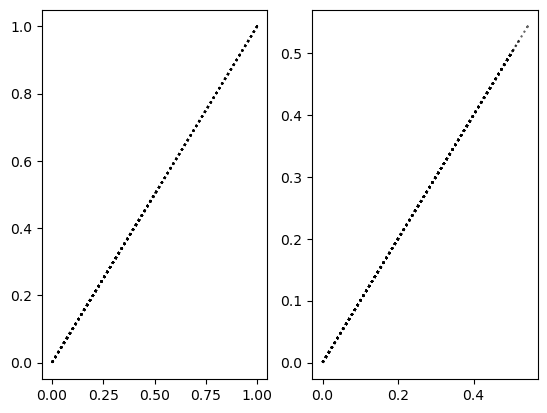

In [144]:
fig, axs = plt.subplots(1, 2)

channel_idx = 0
for name in ['bin_sym', 'bin_asym']:
    
    sim_dict = mean_gillespie_results.get(name)
    
    analytical_dict = mean_field_results.get(name)
    
    for err in all_errors:
        
        common_time, sim_means, sim_lower, sim_higher = sim_dict.get(err)[0]
        analytic_time, analytic_curve = analytical_dict.get(err)[0]
        
        #axs[channel_idx].plot(sim_means[:, 0], sim_means[:, 1], color=colors[dim])
        #axs[channel_idx].fill_between(common_time, sim_means[:, dim], sim_lower[:, dim], 
                                                     #alpha=0.6, color=colors[dim])
        #axs[channel_idx].fill_between(common_time, sim_means[:, dim], sim_higher[:, dim], 
                                                     #alpha=0.6, color=colors[dim])
        axs[channel_idx].plot([y[0] for y in analytic_curve], [y[0] for y in analytic_curve], linestyle='dotted', alpha=0.6, 
                                            color='black', markersize=4)
        
    channel_idx += 1
        
    """     
    axs[error_idx, channel_idx].set_ylim(0, 1.05)


    if error_idx==0:
        axs[error_idx, channel_idx].set_title(name)

    if channel_idx==0:
        axs[error_idx, channel_idx].set_ylabel(f"{float(err):.3}")   

    if channel_idx==num_channels-1:
        axs[error_idx, channel_idx].yaxis.tick_right()
        axs[error_idx, channel_idx].yaxis.set_label_position("right")
        axs[error_idx, channel_idx].set_yticks(np.linspace(0,1,6))
    else:
        axs[error_idx, channel_idx].set_yticks([])

    axs[error_idx, channel_idx].set_xticks([]) 
    """

In [145]:
bin_sym_mf = mean_field_results.get('bin_sym')

In [150]:
bin_sym_test = bin_sym_mf.get(0.01)[0][1]

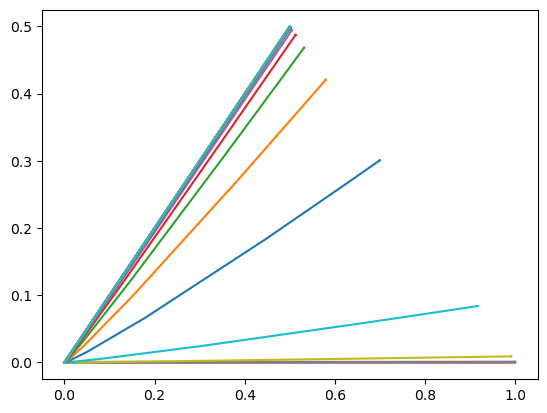

In [152]:
for err in all_errors:
    bin_sym_test = bin_sym_mf.get(err)[0][1]
    plt.plot(bin_sym_test[:, 0], bin_sym_test[:, 1])

In [297]:
fig, axs = plt.subplots(1, 3, figsize=(9, 2))

colormap = plt.cm.plasma # set colormap

for n,name in enumerate(['bin_sym', 'bin_asym_var', 'bin_asym_fixed']):
    
    mf = mean_field_results.get(name)
    #gillespie = mean_gillespie_results.get(name)
    
    for e in range(100):
        
        err = e/100
        
        if name == 'bin_sym':
            channel = single_flip_channel(1, err)
        elif name == 'bin_asym_var':
            channel = bin_asym_channel(0.3, (0.3 - err) % 1)
        elif name == 'bin_asym_fixed':
            channel = bin_asym_channel(err, (err - 0.3 )% 1)
        else: 
            raise ValueError
            
        
            
        initial_state = np.array([1,0])
        
        # Mean Field    
        mean_field = ODE(beta=beta, k=k, channel=channel, T=T)
        analytic_curve = mean_field(initial_state=initial_state/N)
        

        inst = analytic_curve.y.T
        axs[n].plot(inst[:, 0], inst[:, 1], linestyle='dotted', color='k')
        
        # Simulation
        runs = list()
        for _ in tqdm(range(100)):
            
            sim = NoisyGillespie(N=N, initial_state=initial_state, beta=beta, k=k, 
                                channel=channel)
            test_sim = sim.simulate(max_time=T, density=True)
            runs.append((test_sim[0], test_sim[1]))
                                     
        # Interpolating Gillespie Means
        common_time = np.linspace(0, T, T+1)
        interpolated_values = []
        
        for run_t, run_y in runs:
            interp_func = interp1d(run_t, run_y, kind='linear', fill_value='extrapolate', axis=0) 
            interpolated_values.append(interp_func(common_time))
        
        interp_sim_arr = np.array(interpolated_values)
        
        sim_means = np.mean(interp_sim_arr, axis=0)
        
        axs[n].plot(sim_means[:, 0], sim_means[:, 1], color=colormap(err), alpha=0.8)
        
        # Surface
        axs[n].plot([x for x in np.linspace(0, 1, 100)], [1 - x for x in np.linspace(0,1,100)], 'k')
        
        if n > 0:
            axs[n].set_yticks([])
        
    axs[n].set_ylim(0,1)
    axs[n].set_xlim(0,1)

    
# setup the colorbar
normalize = mcolors.Normalize(vmin=0, vmax=1)
scalarmappaple = plt.cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array([i/100 for i in range(100)])
plt.colorbar(scalarmappaple, ax=axs, label=r'$\epsilon$')

fig.savefig('/home/sagar/modeling-info-spread/reports/figures/continuous_phase_space_1d.pdf')

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



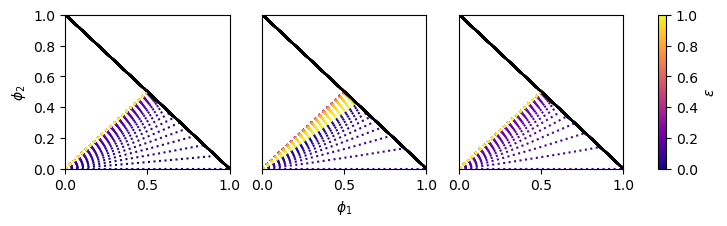

In [506]:
# Change 0.3 to 0.1 in the binary asymmetric

fig, axs = plt.subplots(1, 3, figsize=(9, 2))

colormap = plt.cm.plasma # set colormap

for n,name in enumerate(['bin_sym', 'bin_asym_var', 'bin_asym_fixed']):
    
    mf = mean_field_results.get(name)
    
    for e in range(100):
        
        err = e/100
        
        if name == 'bin_sym':
            channel = single_flip_channel(1, err)
        elif name == 'bin_asym_var':
            channel = bin_asym_channel(0.1, (0.1 - err) % 1)
        elif name == 'bin_asym_fixed':
            channel = bin_asym_channel(err, (err - 0.1 )% 1)
        else: 
            raise ValueError
            
            
        initial_state = np.array([1,0])
        
        # Mean Field    
        mean_field = ODE(beta=beta, k=k, channel=channel, T=T)
        analytic_curve = mean_field(initial_state=initial_state/N)
        

        inst = analytic_curve.y.T
        axs[n].plot(inst[:, 0], inst[:, 1], linestyle='dotted', color=colormap(e/100))
        
        # Surface
        axs[n].plot([x for x in np.linspace(0, 1, 100)], [1 - x for x in np.linspace(0,1,100)], 'k')
        
        if n > 0:
            axs[n].set_yticks([])
        
    axs[n].set_ylim(0,1)
    axs[n].set_xlim(0,1)
    
    if n == 0: 
        axs[n].set_ylabel(r'$\phi_2$')
        
    if n == 1:
        axs[n].set_xlabel(r'$\phi_1$')

    
# setup the colorbar
normalize = mcolors.Normalize(vmin=0, vmax=1)
scalarmappaple = plt.cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array([i/100 for i in range(100)])
plt.colorbar(scalarmappaple, ax=axs, label=r'$\epsilon$')

#fig.savefig('/home/sagar/modeling-info-spread/reports/figures/continuous_phase_space_analytical_only_1d.pdf')

In [217]:
bin_asym_channel(0.3, (0.3 - 0.8) % 1)

array([[0.7, 0.3],
       [0.5, 0.5]])

In [219]:
from matplotlib import tri

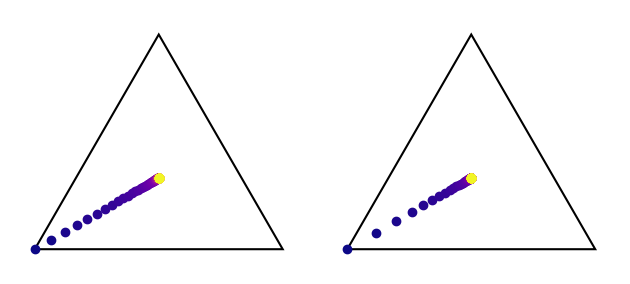

In [377]:
def cartesian_to_barycentric(point):
    
    """
    Convert a 3D point that sums to 1 into 2D Cartesian coordinates on a given triangle.
    
    Parameters:
    point (list or np.array): A 3D point (x, y, z) where x + y + z = 1
    
    Returns:
    np.array: 2D Cartesian coordinates (X, Y)
    """
    #if not np.isclose(sum(point), 1):
    #    raise ValueError("The sum of the point coordinates must be 1.")
    
    # Triangle vertices
    A = np.array([0, 0])
    B = np.array([1, 0])
    C = np.array([0.5, np.sqrt(3) / 2])
    
    # Barycentric coordinates are the same as the 3D point coordinates
    u, v, w = point
    
    # Cartesian coordinates
    P = u * A + v * B + w * C
    
    return P

fig, axs = plt.subplots(1, 2)

vertices = np.array([
    [0, 0],
    [1, 0],
    [0.5, np.sqrt(3)/2]
])
    
colormap = plt.cm.plasma

triangle = plt.Polygon(vertices, edgecolor='k', fill=None, linewidth=1.5)

### First Three-Message Channel
axs[0].add_patch(triangle)

points_3d = []
for e in range(100):
    
    err = e/100
    
    channel = simplex_channel(3, err)
    
    initial_state = np.array([1, 0, 0])
    
    mean_field = ODE(beta=beta, k=k, channel=channel, T=T)
    analytic_curve = mean_field(initial_state=initial_state/N)
    points_3d.append(analytic_curve.y.T[-1])

points_3d = np.array(points_3d)

# Convert to barycentric coordinates
#points_barycentric = cartesian_to_barycentric(points_3d)

for n, point in enumerate(points_3d):
    bary_point = cartesian_to_barycentric(point)
    axs[0].scatter(bary_point[0], bary_point[1], color=colormap(n/100))
    
#Label the vertices
#labels = [r'$\phi_1$', r'$\phi_2$', r'$\phi_3$']
#offset = [(-20, 0), (20, 0), (0, 20) ]
#for i, txt_off in enumerate(zip(labels, offset)):
#    txt = txt_off[0]
#    off = txt_off[1]
#    axs[0].annotate(txt, (vertices[i, 0], vertices[i, 1]), fontsize=15, ha='center',
#               xytext=off, textcoords='offset pixels')

# Set aspect of the plot to be equal
axs[0].set_aspect('equal')

# Set limits and remove ticks
axs[0].set_xlim(-0.1, 1.1)
axs[0].set_ylim(-0.1, np.sqrt(3)/2 + 0.1)
axs[0].set_xticks([])
axs[0].set_yticks([])

for spine in axs[0].spines.values():
    spine.set_visible(False)
    
    
## Second Three-Message Channel
triangle_1 = plt.Polygon(vertices, edgecolor='k', fill=None, linewidth=1.5)
axs[1].add_patch(triangle_1)

points_3d_1 = []
for e in range(100):
    
    err = e/100
    
    channel = star_channel(3, err)
    
    initial_state = np.array([1, 0, 0])
    
    mean_field = ODE(beta=beta, k=k, channel=channel, T=T)
    analytic_curve = mean_field(initial_state=initial_state/N)
    points_3d_1.append(analytic_curve.y.T[-1])

points_3d_1 = np.array(points_3d_1)

# Convert to barycentric coordinates
#points_barycentric = cartesian_to_barycentric(points_3d)

for n, point in enumerate(points_3d_1):
    bary_point = cartesian_to_barycentric(point)
    axs[1].scatter(bary_point[0], bary_point[1], color=colormap(n/100))
    
#Label the vertices
#labels = [r'$\phi_1$', r'$\phi_2$', r'$\phi_3$']
#offset = [(-20, 0), (20, 0), (0, 20) ]
#for i, txt_off in enumerate(zip(labels, offset)):
#    txt = txt_off[0]
#    off = txt_off[1]
#    axs[1].annotate(txt, (vertices[i, 0], vertices[i, 1]), fontsize=15, ha='center',
#               xytext=off, textcoords='offset pixels')

# Set aspect of the plot to be equal
axs[1].set_aspect('equal')

# Set limits and remove ticks
axs[1].set_xlim(-0.1, 1.1)
axs[1].set_ylim(-0.1, np.sqrt(3)/2 + 0.1)
axs[1].set_xticks([])
axs[1].set_yticks([])

for spine in axs[1].spines.values():
    spine.set_visible(False)
    
    
    
plt.tight_layout()

fig.savefig('/home/sagar/modeling-info-spread/reports/figures/continuous_phase_space_analytical_only_2d.pdf')

plt.show()




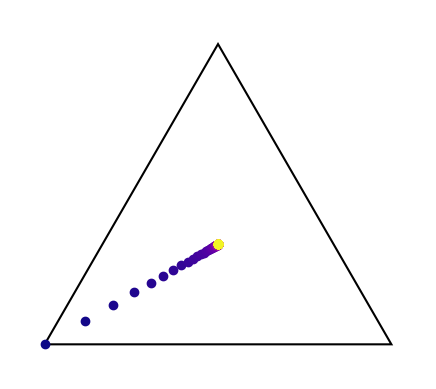

In [282]:
fig, ax = plt.subplots()

vertices = np.array([
    [0, 0],
    [1, 0],
    [0.5, np.sqrt(3)/2]
])
    
colormap = plt.cm.plasma

triangle = plt.Polygon(vertices, edgecolor='k', fill=None, linewidth=1.5)
ax.add_patch(triangle)

points_3d = []
for e in range(100):
    
    err = e/100
    
    channel = star_channel(3, err)
    
    initial_state = np.array([1, 0, 0])
    
    mean_field = ODE(beta=beta, k=k, channel=channel, T=T)
    analytic_curve = mean_field(initial_state=initial_state/N)
    points_3d.append(analytic_curve.y.T[-1])

points_3d = np.array(points_3d)

# Convert to barycentric coordinates
#points_barycentric = cartesian_to_barycentric(points_3d)

for n, point in enumerate(points_3d):
    bary_point = cartesian_to_barycentric(point)
    ax.scatter(bary_point[0], bary_point[1], color=colormap(n/100))
    
#Label the vertices
labels = [r'$\phi_1$', r'$\phi_2$', r'$\phi_3$']
offset = [(-20, 0), (20, 0), (0, 20) ]
for i, txt_off in enumerate(zip(labels, offset)):
    txt = txt_off[0]
    off = txt_off[1]
    ax.annotate(txt, (vertices[i, 0], vertices[i, 1]), fontsize=15, ha='center',
               xytext=off, textcoords='offset pixels')

# Set aspect of the plot to be equal
ax.set_aspect('equal')

# Set limits and remove ticks
ax.set_xlim(-0.1, 1.1)
ax.set_ylim(-0.1, np.sqrt(3)/2 + 0.1)
ax.set_xticks([])
ax.set_yticks([])

for spine in ax.spines.values():
    spine.set_visible(False)
    
    

plt.show()

In [287]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

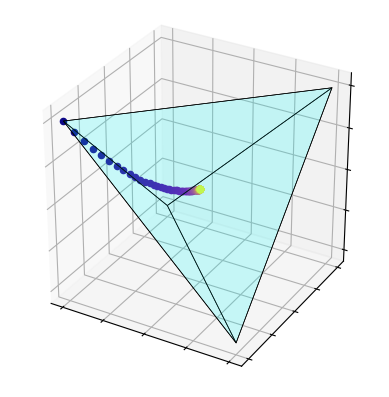

In [375]:
def cartesian_to_barycentric_4d(point, vertices):
    a, b, c, d = point
    return a * vertices[0] + b * vertices[1] + c * vertices[2] + d * vertices[3]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

vertices = np.array([
    [-1, -1, 1],
    [-1, 1, -1],
    [1, -1, -1],
    [1, 1, 1]
])

#vertices = np.array([
#    [-1, -1, -1],
#    [1, -1, -1],
#    [np.sqrt(3)/2, 1, -1],
#    [np.sqrt(3)/2, np.sqrt(3)/2, 1]
#])
    
points_4d = []
for e in range(100):
    
    err = e/100
    
    channel = paw_channel(err)
    
    initial_state = np.array([1, 0, 0, 0])
    
    mean_field = ODE(beta=beta, k=k, channel=channel, T=T)
    analytic_curve = mean_field(initial_state=initial_state/N)
    points_4d.append(analytic_curve.y.T[-1])

for n, point in enumerate(points_4d):
    bary_point = barycentric_to_cartesian_4d(point, vertices)
    ax.scatter(bary_point[0], bary_point[1], bary_point[2], color=colormap(n/100))
    
    
faces = [[vertices[j] for j in [0, 1, 2]],
         [vertices[j] for j in [0, 1, 3]],
         [vertices[j] for j in [0, 2, 3]],
         [vertices[j] for j in [1, 2, 3]]] 

#Label the vertices
#labels = [r'$\phi_1$', r'$\phi_2$', r'$\phi_3$', r'$\phi_4$']
#offset = [(-20, 0), (20, 0), (0, 20), (0, -20)]
#for i, txt_off in enumerate(zip(labels, offset)):
#    txt = txt_off[0]
#    off = txt_off[1]
#    ax.annotate(txt, (vertices[i, 0], vertices[i, 1]), fontsize=15, ha='center',
#               xytext=off, textcoords='offset pixels')
#
ax.add_collection3d(Poly3DCollection(faces, facecolors='cyan', linewidths=0.5, edgecolors='k',
                                     alpha=0.1))

ax.set_box_aspect([1, 1, 1])

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

ax.set_xlim([-1.1, 1.1])
ax.set_ylim([-1.1, 1.1])
ax.set_zlim([-1.1, 1.1])

fig.savefig('/home/sagar/modeling-info-spread/reports/figures/continuous_phase_space_analytical_only_3dd.pdf')

## Poincare Map

In [369]:
channel = single_flip_channel(1, 0.1)
initial_state = np.array([1,0])
mean_field = ODE(beta=beta, k=k, channel=channel, T=T)
analytic_curve = mean_field(initial_state=initial_state/N)

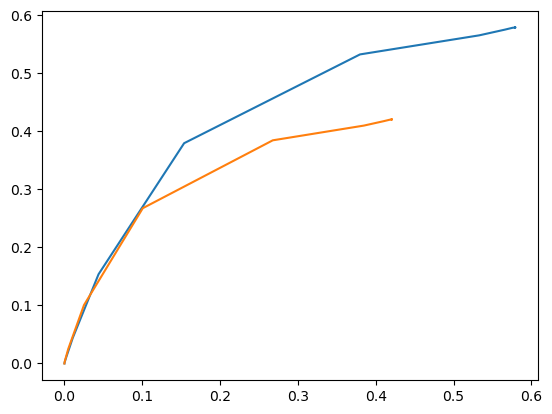

In [371]:
num_pts = analytic_curve.y[0].shape[0]
plt.plot([analytic_curve.y[0][t] for t in range(num_pts-1)], [analytic_curve.y[0][t] for t in range(1,num_pts)])
plt.plot([analytic_curve.y[1][t] for t in range(num_pts-1)], [analytic_curve.y[1][t] for t in range(1,num_pts)])

In [365]:
T

1000

# Conditional Entropy

In [10]:
def shannon_entropy(p: np.ndarray):
    
    """
    Calculate Shannon Entropy 
    
    :param p: 1D np array 
    """
    
    p = p / np.sum(p, axis=1, keepdims=True)
    
    p = p + 1e-7 # ensuring no nans
    
    
    return -1 * np.sum(p * np.log2(p), axis=1)

In [ ]:
fig, axs = plt.subplots(abridged_errors.size, len(mean_gillespie_results.keys()))

channel_idx = 0
for name, sim_dict in mean_gillespie_results.items():
    
    analytical_dict = mean_field_results.get(name)
    
    error_idx = 0
    for err in abridged_errors:
        
        common_time, sim_means, sim_lower, sim_higher = sim_dict.get(err)[0]
        analytic_time, analytic_curve = analytical_dict.get(err)[0]
        
        sim_h = 
        
        for dim in range(sim_means.shape[1]):
            axs[error_idx, channel_idx].plot(common_time, sim_means[:, dim], color=colors[dim])
            #axs[error_idx, channel_idx].fill_between(common_time, sim_means[:, dim], sim_lower[:, dim], 
                                                     #alpha=0.6, color=colors[dim])
            #axs[error_idx, channel_idx].fill_between(common_time, sim_means[:, dim], sim_higher[:, dim], 
                                                     #alpha=0.6, color=colors[dim])
            axs[error_idx, channel_idx].plot(analytic_time, analytic_curve, linestyle='dotted', alpha=0.6, 
                                            color='black', markersize=4)
            
        axs[error_idx, channel_idx].set_ylim(0, 1.05)
        

        if error_idx==0:
            axs[error_idx, channel_idx].set_title(name)

        if channel_idx==0:
            axs[error_idx, channel_idx].set_ylabel(f"{float(err):.3}")   

        if channel_idx==num_channels-1:
            axs[error_idx, channel_idx].yaxis.tick_right()
            axs[error_idx, channel_idx].yaxis.set_label_position("right")
            axs[error_idx, channel_idx].set_yticks(np.linspace(0,1,6))
        else:
            axs[error_idx, channel_idx].set_yticks([])

        axs[error_idx, channel_idx].set_xticks([]) 
        
        error_idx += 1
        
    channel_idx += 1

In [443]:
shannon_entropy(mean_field_results.get('bin_sym').get(0.1)[0][1])

array([0.00133228, 0.00134956, 0.00153146, 0.00519923, 0.0283739 ,
       0.10798344, 0.33156615, 0.74888302, 1.03944018, 1.01415033,
       0.99233568, 0.9848407 , 0.98232315, 0.98186976, 0.98183405,
       0.9820349 , 0.98197104, 0.98192166, 0.98201761, 0.98202486,
       0.98183288])

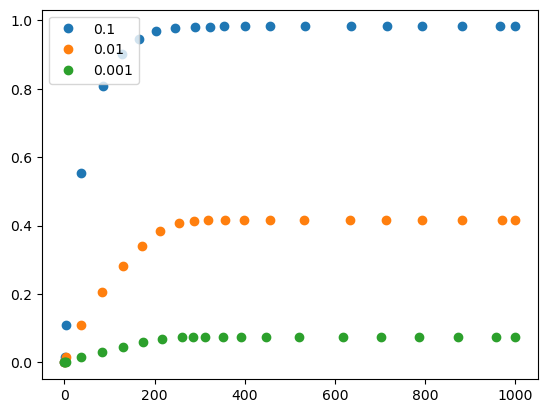

In [477]:
plt.plot(mean_field_results.get('bin_sym').get(0.1)[0][0], 
         shannon_entropy(mean_field_results.get('bin_sym').get(0.1)[0][1]), 'o',
        label='0.1')


plt.plot(mean_field_results.get('bin_sym').get(0.01)[0][0], 
         shannon_entropy(mean_field_results.get('bin_sym').get(0.01)[0][1]), 'o',
        label='0.01')


plt.plot(mean_field_results.get('bin_sym').get(0.001)[0][0], 
         shannon_entropy(mean_field_results.get('bin_sym').get(0.001)[0][1]), 'o',
        label='0.001')

plt.legend()

In [448]:
mean_gillespie_results.get('bin_sym').get(0.1)[0]

(array([   0.,    1.,    2., ...,  998.,  999., 1000.]),
 array([[1.00000000e-04, 0.00000000e+00],
        [1.13854052e-04, 2.67647718e-06],
        [1.21748575e-04, 4.27836734e-06],
        ...,
        [5.86882772e-01, 4.27027978e-01],
        [5.86897072e-01, 4.27040453e-01],
        [5.86911372e-01, 4.27052927e-01]]),
 array([[1.00000000e-04, 0.00000000e+00],
        [1.08221611e-04, 2.87638514e-07],
        [1.15208491e-04, 9.48467645e-07],
        ...,
        [5.70908501e-01, 4.11522445e-01],
        [5.70917815e-01, 4.11529372e-01],
        [5.70927124e-01, 4.11536289e-01]]),
 array([[1.00000000e-04, 0.00000000e+00],
        [1.19486492e-04, 5.06531584e-06],
        [1.28288660e-04, 7.60826703e-06],
        ...,
        [6.02857043e-01, 4.42533510e-01],
        [6.02876329e-01, 4.42551533e-01],
        [6.02895620e-01, 4.42569565e-01]]))

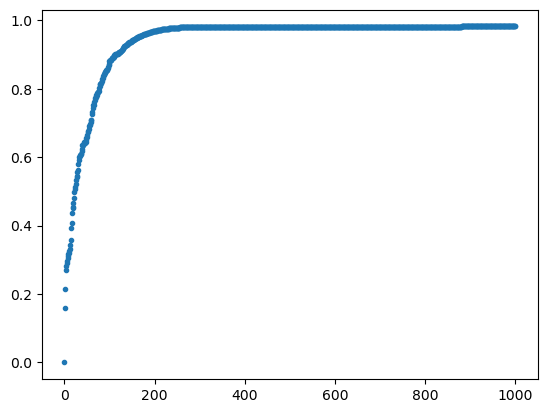

In [471]:
plt.plot(mean_gillespie_results.get('bin_sym').get(0.1)[0][0], shannon_entropy(mean_gillespie_results.get('bin_sym').get(0.1)[0][1]), '.')
#plt.plot(mean_gillespie_results.get('bin_sym').get(0.1)[0][0], shannon_entropy(mean_gillespie_results.get('bin_sym').get(0.1)[0][2]), '-')
#plt.plot(mean_gillespie_results.get('bin_sym').get(0.1)[0][0], shannon_entropy(mean_gillespie_results.get('bin_sym').get(0.1)[0][3]), '-')


#plt.fill_between(mean_gillespie_results.get('bin_sym').get(0.1)[0][0], shannon_entropy(mean_gillespie_results.get('bin_sym').get(0.1)[0][2]), shannon_entropy(mean_gillespie_results.get('bin_sym').get(0.1)[0][3]))

In [461]:
mean_gillespie_results.get('bin_sym').get(0.1)[0][1]

array([0.32895587, 0.23230586])

## 

## Entropy Increase by Error

In [ ]:
## ADD SIMULATIONS TO THIS

# Save as 0.1 asym

#fig, axs = plt.subplots(2, 3, figsize=(9, 4))
num_runs = 100
resolution = 100

final_dists = []

colormap = plt.cm.plasma # set colormap

#for n,name in tqdm(enumerate(['bin_sym', 'bin_asym_var', 'bin_asym_fixed', 
#                        'triangle', 'cherry', 'paw'])):
    
for n,name in tqdm(enumerate(['bin_sym', 'bin_asym_var','triangle', 'cherry', 'paw'])):
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    #mf = mean_field_results.get(name)
    final_dist = []
    
    cond_sim_means = []
    
    for e in range(resolution):
        
        err = e/resolution
        
        if name == 'bin_sym':
            channel = single_flip_channel(1, err)
        elif name == 'bin_asym_var':
            channel = bin_asym_channel(0.1, (0.1 - err) % 1)
        elif name == 'bin_asym_fixed':
            channel = bin_asym_channel(err, (err - 0.1)% 1)
        elif name == 'triangle': 
            channel = simplex_channel(3, err)
        elif name == 'cherry': 
            channel = star_channel(3, err)
        elif name == 'paw': 
            channel = paw_channel(err)
        else: 
            raise ValueError
            
            
        initial_state = np.array([1] + [0]*(channel.shape[0]-1))
        
        cond_ent_runs = []
        # Noisy Gillespie Algorithm
        runs_x1 = list()
        for _ in tqdm(range(num_runs)):

            sim_x1 = NoisyGillespie(N=N, initial_state=initial_state, beta=beta, k=k, 
                                channel=channel)
            test_sim = sim_x1.simulate(max_time=T, density=True)
            runs_x1.append(test_sim[1][-1])

        se = np.std(shannon_entropy(np.array(runs_x1))) / np.sqrt(num_runs)
        conf_int = 1.96 * MI_se

        sim_means = np.mean(shannon_entropy(np.array(runs_x1)))
        cond_sim_means.append((sim_means, conf_int))
        
        # Mean Field    
        mean_field = ODE(beta=beta, k=k, channel=channel, T=T)
        analytic_curve = mean_field(initial_state=initial_state/N)
        

        inst = analytic_curve.y.T
        
        final_dist.append(inst[-1, :])
        
    ax.set_yscale('linear')    
    ax.plot([e/resolution for e in range(resolution)], shannon_entropy(np.array(final_dist)), 
                        '+', color='darkorange')
    ax.errorbar(x=[e/resolution for e in range(resolution)], y=[tup[0] for tup in cond_sim_means], 
                 yerr=[tup[1] for tup in cond_sim_means], marker='.', linestyle='none', 
                 color='indigo', ecolor='darkviolet')
    fig.savefig(f'/home/sagar/modeling-info-spread/reports/figures/conditional_entropy_{name}-lin.pdf')
    
    ax.set_yscale('log')
    ax.plot([e/resolution for e in range(resolution)], shannon_entropy(np.array(final_dist)), 
                        '+', color='darkorange')
    ax.errorbar(x=[e/resolution for e in range(resolution)], y=[tup[0] for tup in cond_sim_means], 
                 yerr=[tup[1] for tup in cond_sim_means], marker='.', linestyle='none', 
                 color='indigo', ecolor='darkviolet')
    fig.savefig(f'/home/sagar/modeling-info-spread/reports/figures/conditional_entropy_{name}-log.pdf')

        
    #axs[n // 3, n % 3].plot([e/1000 for e in range(1000)], shannon_entropy(np.array(final_dist)), 
    #                        '.', color='purple', markersize=0.7)
    #axs[n // 3, n % 3].axhline(np.log2(initial_state.shape), 0, 1, linestyle='dashed', color='k', linewidth=0.8)
    #
    #if n // 3 == 0:
    #    axs[n // 3, n % 3].set_xticks([])
    #
    #final_dists.append(final_dist)
    #    
        
    
#fig.savefig('/home/sagar/modeling-info-spread/reports/figures/temporary_H_by_eps.pdf')

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

# Mutual Information

In [517]:
def mutual_info(M, X):
    # Ensure the inputs are normalized
    assert np.isclose(np.sum(X), 1.0), "X should be normalized"
    assert np.all(np.isclose(np.sum(M, axis=1), 1.0)), "Rows of M should sum to 1"

    num_x = M.shape[0]
    num_y = M.shape[1]

    # Calculate p(y)
    p_y = np.dot(X, M)

    # Calculate p(x, y)
    p_xy = np.zeros((num_x, num_y))
    for x in range(num_x):
        for y in range(num_y):
            p_xy[x, y] = X[x] * M[x, y]

    def log_term(x, y):
        if p_xy[x, y] > 0 and p_y[y] > 0:  # Ensure we don't divide by zero or take log of zero
            log_value = np.log2(p_xy[x, y] / (X[x] * p_y[y]))
            return log_value
        return 0

    I = np.sum([p_xy[x, y] * log_term(x, y) for x in range(num_x) for y in range(num_y)])
    
    return I

# Example usage:
M = np.array([[0.28, 0.72], [0.72, 0.28]])
X = np.array([0.5, 0.5])
result = mutual_info(M, X)
print("Mutual Information:", result)

Mutual Information: 0.14454918943986927


In [ ]:
# mutual info requires E to be a channel... So do we keep Q fixed as bin sym and vary E?

In [539]:
#fig, axs = plt.subplots(1, len(mean_gillespie_results.keys()))

resolution = 20

X = np.array([0.5, 0.5]) # Hard-Code uniform input distribution

channel_idx = 0
for name, channel_dict in channel_mapping.items():
    
    channel = channel_dict.get(0.01) # Hard-Coding distortion likelihood of 0.01 so perfect encoding is good
    
    MI_phi = []
    MI_enc = []
    
    for dim in range(channel.shape[0]):
        
        X = np.array([1/channel.shape[0]]*channel.shape[0])
        
        # Creating all N-tuples of initial coords --- THIS DOESN'T WORK
        
        # Need to create BSC and vary the distortion from 0 to 0.5 to sweep through the possible values
        # Same goes for higher dimensions
        
        coords = np.linspace(0, 1, resolution+1)
        grid = np.meshgrid(*[coords]*2, indexing='ij')
        points = np.stack(grid, axis=-1).reshape(-1, 2)
        
        #########
        X1 = np.array([1, 0])
        X2 = np.array([0, 1])
        
        for err in np.linspace(0, 1, resolution + 1):
            
            E = single_flip_channel(1, err)
            MI_enc.append(mutual_info(E, X))
        
            initial_state_x1 = E @ X1
            initial_state_x2 = E @ X2

            # Mean Field    
            mean_field_x1 = ODE(beta=beta, k=k, channel=channel, T=T)
            analytic_curve_x1 = mean_field(initial_state=initial_state_x1/N)
            analytic_curve_x2 = mean_field(initial_state=initial_state_x2/N)

            M1 = analytic_curve_x1.y.T
            M2 = analytic_curve_x2.y.T
            
            
        
        
        
        
    

AxisError: axis 1 is out of bounds for array of dimension 1

# Mutual Information Binary Symmetric

## Varying Encoding Performance

In [759]:
resolution = 100
channel = single_flip_channel(1, 0.001)
num_runs = 100

X1 = np.array([1, 0])
X2 = np.array([0, 1])

MI_enc = []
MI_phi = []
MI_sim = []



for err in np.linspace(0, 1, resolution + 1):

    E = single_flip_channel(1, err)
    MI_enc.append(mutual_info(E, X))

    initial_state_x1 = E @ X1
    initial_state_x2 = E @ X2
    
    # Gillespie
    # Noisy Gillespie Algorithm
    runs_x1 = list()
    for _ in tqdm(range(num_runs)):

        sim_x1 = NoisyGillespie(N=N, initial_state=initial_state_x1, beta=beta, k=k, 
                            channel=channel)
        test_sim = sim_x1.simulate(max_time=T, density=True)
        runs_x1.append((test_sim[0], test_sim[1]))
        
    runs_x2 = list()
    for _ in tqdm(range(num_runs)):

        sim_x2 = NoisyGillespie(N=N, initial_state=initial_state_x2, beta=beta, k=k, 
                            channel=channel)
        test_sim = sim_x2.simulate(max_time=T, density=True)
        runs_x2.append((test_sim[0], test_sim[1]))

    # Interpolating Gillespie Means
    MI_sim_runs = []
    
    common_time = np.linspace(0, T, T+1)
    #interpolated_values_x1 = []
    #interpolated_values_x2 = []

    #for run_t, run_y in runs_x1:
    #    interp_func = interp1d(run_t, run_y, kind='linear', fill_value='extrapolate', axis=0) 
    #    interpolated_values_x1.append(interp_func(common_time))
    #for run_t, run_y in runs_x2:
    #    interp_func = interp1d(run_t, run_y, kind='linear', fill_value='extrapolate', axis=0) 
    #    interpolated_values_x2.append(interp_func(common_time))

    #interp_sim_arr_x1 = np.array(interpolated_values_x1)
    #interp_sim_arr_x2 = np.array(interpolated_values_x2)

    #for arr1, arr2 in tqdm(zip(interp_sim_arr_x1, interp_sim_arr_x2)):
    #    sim_phi_x1 = arr1[-1]/np.sum(arr1[-1])
    #    sim_phi_x2 = arr2[-1]/np.sum(arr2[-1])
    #    MI_sim_runs.append(mutual_info(np.stack([sim_phi_x1, sim_phi_x2]), X))
    
    for arr1, arr2 in tqdm(zip([tup[1] for tup in runs_x1], [tup[1] for tup in runs_x2])):
        sim_phi_x1 = arr1[-1]/np.sum(arr1[-1])
        sim_phi_x2 = arr2[-1]/np.sum(arr2[-1])
        MI_sim_runs.append(mutual_info(np.stack([sim_phi_x1, sim_phi_x2]), X))
        
    MI_se = np.std(np.array(MI_sim_runs)) / np.sqrt(num_runs)
    MI_conf_int = 1.96 * MI_se
    
    MI_sim_means = np.mean(np.array(MI_sim_runs))
    
    #MI_sim_lower = MI_sim_means - MI_conf_int
    #MI_sim_higher = MI_sim_means + MI_conf_int

    #MI_sim_lower = np.clip(MI_sim_lower, 0, 1)
    #MI_sim_higher = np.clip(MI_sim_higher, 0, 1)

    # Mean Field    
    mean_field = ODE(beta=beta, k=k, channel=channel, T=T)
    analytic_curve_x1 = mean_field(initial_state=initial_state_x1/N)
    analytic_curve_x2 = mean_field(initial_state=initial_state_x2/N)

    M1 = analytic_curve_x1.y.T
    M2 = analytic_curve_x2.y.T
    
    last_phi_x1 = M1[-1]/np.sum(M1[-1])
    last_phi_x2 = M2[-1]/np.sum(M2[-1])
    
    # for t in M1... MI_phi.apped
    
    MI_phi.append(mutual_info(np.stack([last_phi_x1, last_phi_x2]), X))
    MI_sim.append((MI_sim_means, MI_conf_int))

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

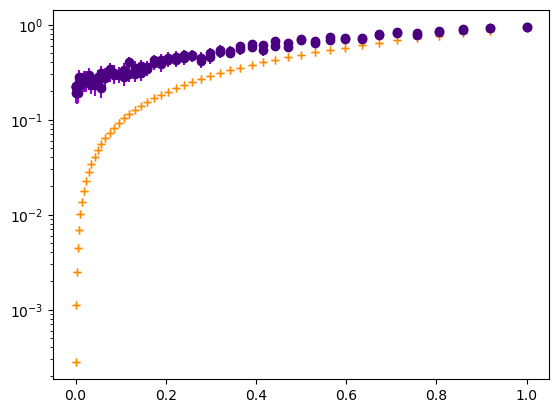

In [764]:
plt.plot(MI_enc, MI_phi, '+', color='darkorange')
plt.errorbar(x=MI_enc, y=[tup[0] for tup in MI_sim], yerr=[tup[1] for tup in MI_sim], marker='o',
            linestyle='none', color='indigo', ecolor='darkviolet')
plt.yscale('log')
#plt.savefig('/home/sagar/modeling-info-spread/reports/figures/mutual-info-error-by-error-binsym-log.pdf')
plt.show()

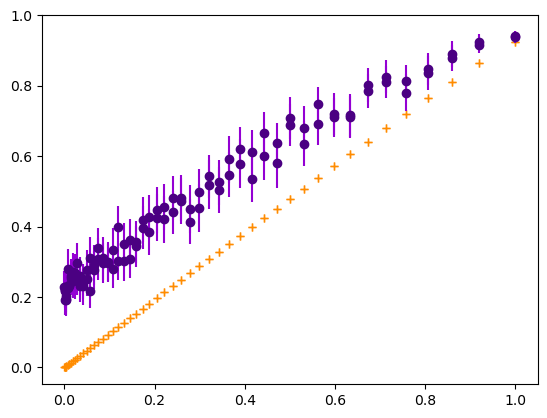

In [765]:
plt.plot(MI_enc, MI_phi, '+', color='darkorange')
plt.errorbar(x=MI_enc, y=[tup[0] for tup in MI_sim], yerr=[tup[1] for tup in MI_sim], marker='o',
            linestyle='none', color='indigo', ecolor='darkviolet')
#plt.savefig('/home/sagar/modeling-info-spread/reports/figures/mutual-info-error-by-error-binsym-lin.pdf')
plt.show()

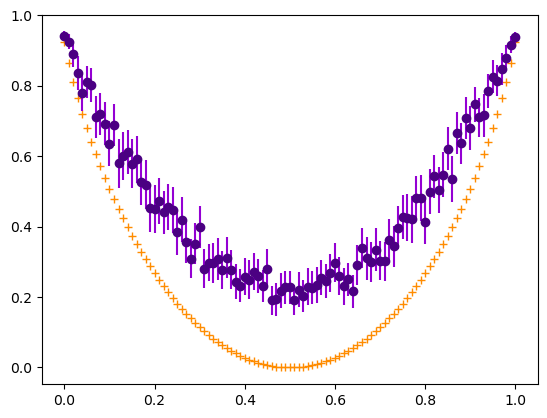

In [766]:
plt.plot(np.linspace(0, 1, 101), MI_phi, '+', color='darkorange')
plt.errorbar(x=np.linspace(0, 1, 101), y=[tup[0] for tup in MI_sim], yerr=[tup[1] for tup in MI_sim], marker='o',
            linestyle='none', color='indigo', ecolor='darkviolet')
#plt.savefig('/home/sagar/modeling-info-spread/reports/figures/mutual-info-distortion-by-error-binsym.pdf')

## Varying Channel Distortion

In [768]:
resolution = 100
num_runs = 100

X1 = np.array([1, 0])
X2 = np.array([0, 1])

MI_phi = []
MI_sim = []



for err in np.linspace(0, 1, resolution + 1):

    channel = single_flip_channel(1, err)

    initial_state_x1 = X1
    initial_state_x2 = X2
    
    # Gillespie
    # Noisy Gillespie Algorithm
    runs_x1 = list()
    for _ in tqdm(range(num_runs)):

        sim_x1 = NoisyGillespie(N=N, initial_state=initial_state_x1, beta=beta, k=k, 
                            channel=channel)
        test_sim = sim_x1.simulate(max_time=T, density=True)
        runs_x1.append((test_sim[0], test_sim[1]))
        
    runs_x2 = list()
    for _ in tqdm(range(num_runs)):

        sim_x2 = NoisyGillespie(N=N, initial_state=initial_state_x2, beta=beta, k=k, 
                            channel=channel)
        test_sim = sim_x2.simulate(max_time=T, density=True)
        runs_x2.append((test_sim[0], test_sim[1]))

    # Interpolating Gillespie Means
    MI_sim_runs = []
    
    common_time = np.linspace(0, T, T+1)
    #interpolated_values_x1 = []
    #interpolated_values_x2 = []
#
    #for run_t, run_y in runs_x1:
    #    interp_func = interp1d(run_t, run_y, kind='linear', fill_value='extrapolate', axis=0) 
    #    interpolated_values_x1.append(interp_func(common_time))
    #for run_t, run_y in runs_x2:
    #    interp_func = interp1d(run_t, run_y, kind='linear', fill_value='extrapolate', axis=0) 
    #    interpolated_values_x2.append(interp_func(common_time))
#
    #interp_sim_arr_x1 = np.array(interpolated_values_x1)
    #interp_sim_arr_x2 = np.array(interpolated_values_x2)
#
    #for arr1, arr2 in tqdm(zip(interp_sim_arr_x1, interp_sim_arr_x2)):
    #    sim_phi_x1 = arr1[-1]/np.sum(arr1[-1])
    #    sim_phi_x2 = arr2[-1]/np.sum(arr2[-1])
    #    MI_sim_runs.append(mutual_info(np.stack([sim_phi_x1, sim_phi_x2]), X))
    
    for arr1, arr2 in tqdm(zip([tup[1] for tup in runs_x1], [tup[1] for tup in runs_x2])):
        sim_phi_x1 = arr1[-1]/np.sum(arr1[-1])
        sim_phi_x2 = arr2[-1]/np.sum(arr2[-1])
        MI_sim_runs.append(mutual_info(np.stack([sim_phi_x1, sim_phi_x2]), X))
        
    MI_se = np.std(np.array(MI_sim_runs)) / np.sqrt(num_runs)
    MI_conf_int = 1.96 * MI_se
    
    MI_sim_means = np.mean(np.array(MI_sim_runs))
    
    #MI_sim_lower = MI_sim_means - MI_conf_int
    #MI_sim_higher = MI_sim_means + MI_conf_int

    #MI_sim_lower = np.clip(MI_sim_lower, 0, 1)
    #MI_sim_higher = np.clip(MI_sim_higher, 0, 1)

    # Mean Field    
    mean_field = ODE(beta=beta, k=k, channel=channel, T=T)
    analytic_curve_x1 = mean_field(initial_state=initial_state_x1/N)
    analytic_curve_x2 = mean_field(initial_state=initial_state_x2/N)

    M1 = analytic_curve_x1.y.T
    M2 = analytic_curve_x2.y.T
    
    last_phi_x1 = M1[-1]/np.sum(M1[-1])
    last_phi_x2 = M2[-1]/np.sum(M2[-1])
    
    # for t in M1... MI_phi.apped
    
    MI_phi.append(mutual_info(np.stack([last_phi_x1, last_phi_x2]), X))
    MI_sim.append((MI_sim_means, MI_conf_int))

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

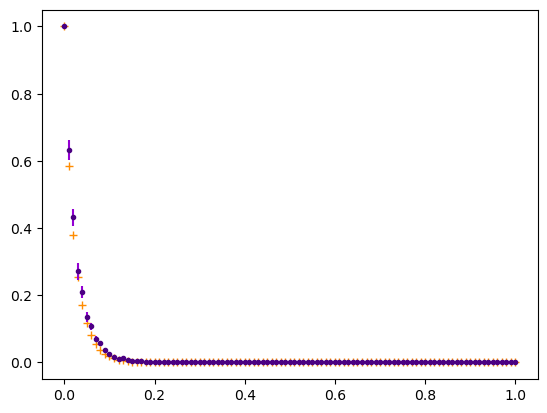

In [782]:
plt.plot(np.linspace(0, 1, 101), MI_phi, '+', color='darkorange')
plt.errorbar(x=np.linspace(0, 1, 101), y=[tup[0] for tup in MI_sim], yerr=[tup[1] for tup in MI_sim], marker='.',
            linestyle='none', color='indigo', ecolor='darkviolet')
#plt.yscale('log')
plt.savefig('/home/sagar/modeling-info-spread/reports/figures/mutual-info-channel-binsym-lin.pdf')

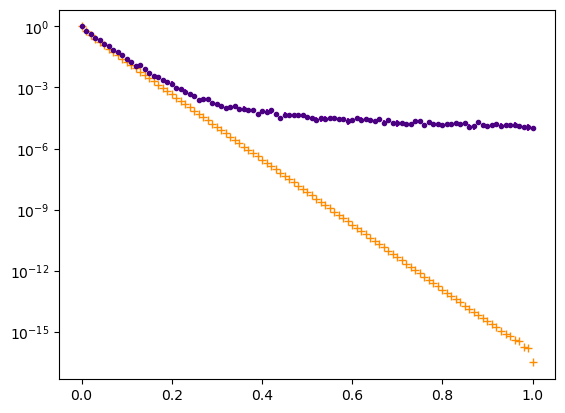

In [783]:
plt.plot(np.linspace(0, 1, 101), MI_phi, '+', color='darkorange')
plt.errorbar(x=np.linspace(0, 1, 101), y=[tup[0] for tup in MI_sim], yerr=[tup[1] for tup in MI_sim], marker='.',
            linestyle='none', color='indigo', ecolor='darkviolet')
plt.yscale('log')
plt.savefig('/home/sagar/modeling-info-spread/reports/figures/mutual-info-channel-binsym-log.pdf')

# Mutual Information Binary Asymmetric

## Verying Encoding Performance

In [811]:
resolution = 100
channel = single_flip_channel(1, 0.001)
num_runs = 100

X1 = np.array([1, 0])
X2 = np.array([0, 1])

MI_enc = []
MI_phi = []
MI_sim = []



for err in np.linspace(0, 1, resolution + 1):

    E = bin_asym_channel(0.1, (0.1 - err) % 1)
    MI_enc.append(mutual_info(E, X))

    initial_state_x1 = E @ X1
    initial_state_x2 = E @ X2
    
    # Gillespie
    # Noisy Gillespie Algorithm
    runs_x1 = list()
    for _ in tqdm(range(num_runs)):

        sim_x1 = NoisyGillespie(N=N, initial_state=initial_state_x1, beta=beta, k=k, 
                            channel=channel)
        test_sim = sim_x1.simulate(max_time=T, density=True)
        runs_x1.append((test_sim[0], test_sim[1]))
        
    runs_x2 = list()
    for _ in tqdm(range(num_runs)):

        sim_x2 = NoisyGillespie(N=N, initial_state=initial_state_x2, beta=beta, k=k, 
                            channel=channel)
        test_sim = sim_x2.simulate(max_time=T, density=True)
        runs_x2.append((test_sim[0], test_sim[1]))

    # Interpolating Gillespie Means
    MI_sim_runs = []
    
    common_time = np.linspace(0, T, T+1)
    interpolated_values_x1 = []
    interpolated_values_x2 = []

    for run_t, run_y in runs_x1:
        interp_func = interp1d(run_t, run_y, kind='linear', fill_value='extrapolate', axis=0) 
        interpolated_values_x1.append(interp_func(common_time))
    for run_t, run_y in runs_x2:
        interp_func = interp1d(run_t, run_y, kind='linear', fill_value='extrapolate', axis=0) 
        interpolated_values_x2.append(interp_func(common_time))

    interp_sim_arr_x1 = np.array(interpolated_values_x1)
    interp_sim_arr_x2 = np.array(interpolated_values_x2)

    for arr1, arr2 in tqdm(zip(interp_sim_arr_x1, interp_sim_arr_x2)):
        sim_phi_x1 = arr1[-1]/np.sum(arr1[-1])
        sim_phi_x2 = arr2[-1]/np.sum(arr2[-1])
        MI_sim_runs.append(mutual_info(np.stack([sim_phi_x1, sim_phi_x2]), X))
        
    MI_se = np.std(np.array(MI_sim_runs)) / np.sqrt(num_runs)
    MI_conf_int = 1.96 * MI_se
    
    MI_sim_means = np.mean(np.array(MI_sim_runs))
    
    #MI_sim_lower = MI_sim_means - MI_conf_int
    #MI_sim_higher = MI_sim_means + MI_conf_int

    #MI_sim_lower = np.clip(MI_sim_lower, 0, 1)
    #MI_sim_higher = np.clip(MI_sim_higher, 0, 1)

    # Mean Field    
    mean_field = ODE(beta=beta, k=k, channel=channel, T=T)
    analytic_curve_x1 = mean_field(initial_state=initial_state_x1/N)
    analytic_curve_x2 = mean_field(initial_state=initial_state_x2/N)

    M1 = analytic_curve_x1.y.T
    M2 = analytic_curve_x2.y.T
    
    last_phi_x1 = M1[-1]/np.sum(M1[-1])
    last_phi_x2 = M2[-1]/np.sum(M2[-1])
    
    # for t in M1... MI_phi.apped
    
    MI_phi.append(mutual_info(np.stack([last_phi_x1, last_phi_x2]), X))
    MI_sim.append((MI_sim_means, MI_conf_int))

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



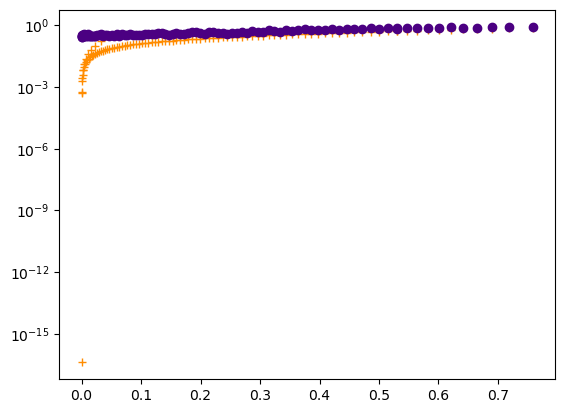

In [787]:
plt.plot(MI_enc, MI_phi, '+', color='darkorange')
plt.errorbar(x=MI_enc, y=[tup[0] for tup in MI_sim], yerr=[tup[1] for tup in MI_sim], marker='o',
            linestyle='none', color='indigo', ecolor='darkviolet')
plt.yscale('log')
#plt.savefig('/home/sagar/modeling-info-spread/reports/figures/mutual-info-error-by-error-binasym-log.pdf')
plt.show()

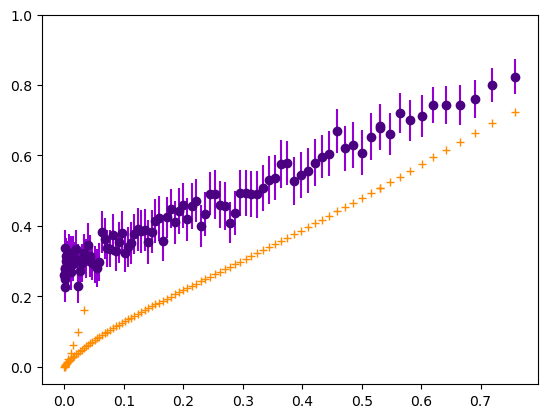

In [822]:
plt.plot(MI_enc, MI_phi, '+', color='darkorange')
plt.errorbar(x=MI_enc, y=[tup[0] for tup in MI_sim], yerr=[tup[1] for tup in MI_sim], marker='o',
            linestyle='none', color='indigo', ecolor='darkviolet')
#plt.yscale('log')
plt.ylim(-0.05,1)
plt.savefig('/home/sagar/modeling-info-spread/reports/figures/mutual-info-error-by-error-binasym-log.pdf')
plt.show()

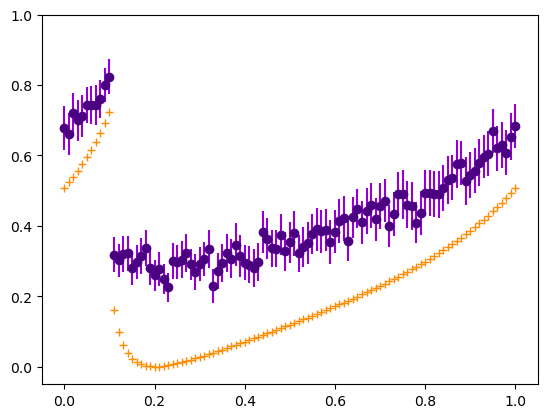

In [823]:
plt.plot(np.linspace(0, 1, 101), MI_phi, '+', color='darkorange')
plt.errorbar(x=np.linspace(0, 1, 101), y=[tup[0] for tup in MI_sim], yerr=[tup[1] for tup in MI_sim], marker='o',
            linestyle='none', color='indigo', ecolor='darkviolet')
plt.ylim(-0.05,1)
plt.savefig('/home/sagar/modeling-info-spread/reports/figures/mutual-info-distortion-by-error-binasym.pdf')

# Varying Channel Distortion

In [797]:
resolution = 100
num_runs = 100

X1 = np.array([1, 0])
X2 = np.array([0, 1])

MI_enc = []
MI_phi = []
MI_sim = []



for err in np.linspace(0, 1, resolution + 1):

    channel = bin_asym_channel(0.1, (0.1 - err) % 1)

    initial_state_x1 = X1
    initial_state_x2 = X2
    
    # Gillespie
    # Noisy Gillespie Algorithm
    runs_x1 = list()
    for _ in tqdm(range(num_runs)):

        sim_x1 = NoisyGillespie(N=N, initial_state=initial_state_x1, beta=beta, k=k, 
                            channel=channel)
        test_sim = sim_x1.simulate(max_time=T, density=True)
        runs_x1.append((test_sim[0], test_sim[1]))
        
    runs_x2 = list()
    for _ in tqdm(range(num_runs)):

        sim_x2 = NoisyGillespie(N=N, initial_state=initial_state_x2, beta=beta, k=k, 
                            channel=channel)
        test_sim = sim_x2.simulate(max_time=T, density=True)
        runs_x2.append((test_sim[0], test_sim[1]))

    # Interpolating Gillespie Means
    MI_sim_runs = []
    
    common_time = np.linspace(0, T, T+1)
    interpolated_values_x1 = []
    interpolated_values_x2 = []

    for run_t, run_y in runs_x1:
        interp_func = interp1d(run_t, run_y, kind='linear', fill_value='extrapolate', axis=0) 
        interpolated_values_x1.append(interp_func(common_time))
    for run_t, run_y in runs_x2:
        interp_func = interp1d(run_t, run_y, kind='linear', fill_value='extrapolate', axis=0) 
        interpolated_values_x2.append(interp_func(common_time))

    interp_sim_arr_x1 = np.array(interpolated_values_x1)
    interp_sim_arr_x2 = np.array(interpolated_values_x2)

    for arr1, arr2 in tqdm(zip(interp_sim_arr_x1, interp_sim_arr_x2)):
        sim_phi_x1 = arr1[-1]/np.sum(arr1[-1])
        sim_phi_x2 = arr2[-1]/np.sum(arr2[-1])
        MI_sim_runs.append(mutual_info(np.stack([sim_phi_x1, sim_phi_x2]), X))
        
    MI_se = np.std(np.array(MI_sim_runs)) / np.sqrt(num_runs)
    MI_conf_int = 1.96 * MI_se
    
    MI_sim_means = np.mean(np.array(MI_sim_runs))
    
    #MI_sim_lower = MI_sim_means - MI_conf_int
    #MI_sim_higher = MI_sim_means + MI_conf_int

    #MI_sim_lower = np.clip(MI_sim_lower, 0, 1)
    #MI_sim_higher = np.clip(MI_sim_higher, 0, 1)

    # Mean Field    
    mean_field = ODE(beta=beta, k=k, channel=channel, T=T)
    analytic_curve_x1 = mean_field(initial_state=initial_state_x1/N)
    analytic_curve_x2 = mean_field(initial_state=initial_state_x2/N)

    M1 = analytic_curve_x1.y.T
    M2 = analytic_curve_x2.y.T
    
    last_phi_x1 = M1[-1]/np.sum(M1[-1])
    last_phi_x2 = M2[-1]/np.sum(M2[-1])
    
    # for t in M1... MI_phi.apped
    
    MI_phi.append(mutual_info(np.stack([last_phi_x1, last_phi_x2]), X))
    MI_sim.append((MI_sim_means, MI_conf_int))

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



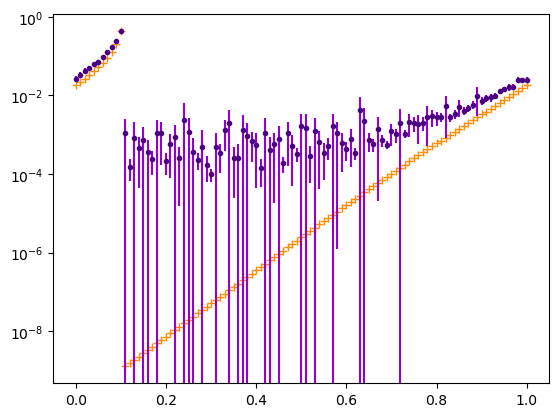

In [801]:
plt.plot(np.linspace(0, 1, 101), MI_phi, '+', color='darkorange')
plt.errorbar(x=np.linspace(0, 1, 101), y=[tup[0] for tup in MI_sim], yerr=[tup[1] for tup in MI_sim], marker='.',
            linestyle='none', color='indigo', ecolor='darkviolet')
plt.yscale('log')
plt.savefig('/home/sagar/modeling-info-spread/reports/figures/mutual-info-channel-binasym-log.pdf')

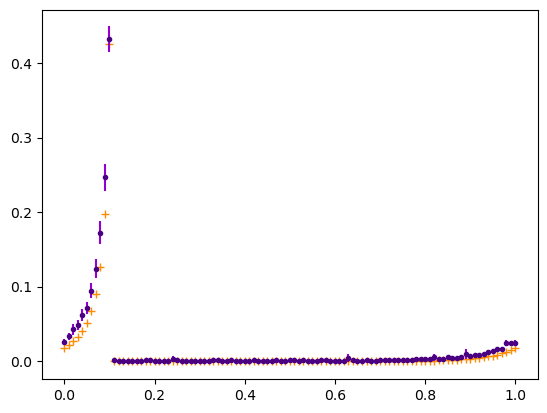

In [800]:
plt.plot(np.linspace(0, 1, 101), MI_phi, '+', color='darkorange')
plt.errorbar(x=np.linspace(0, 1, 101), y=[tup[0] for tup in MI_sim], yerr=[tup[1] for tup in MI_sim], marker='.',
            linestyle='none', color='indigo', ecolor='darkviolet')
#plt.yscale('log')
plt.savefig('/home/sagar/modeling-info-spread/reports/figures/mutual-info-channel-binasym-lin.pdf')

# Over Time with Perfect Encoding

In [808]:
MI_sim_runs = []
analytic_MI = []

analytical_time = None

num_runs = 100

X = [1/2, 1/2]

for channel in [single_flip_channel(1, 0.1)]:
    
    X1 = np.array([1, 0])
    X2 = np.array([0, 1])
    
    #E = single_flip_channel(1, 0.1)
    #    
    #initial_state_x1 = E @ X1
    #initial_state_x2 = E @ X2
    
    # Perfect Encoding
    initial_state_x1 = X1
    initial_state_x2 = X2

    # Noisy Gillespie Algorithm
    runs_x1 = list()
    for _ in tqdm(range(num_runs)):

        sim_x1 = NoisyGillespie(N=N, initial_state=initial_state_x1, beta=beta, k=k, 
                            channel=channel)
        test_sim = sim_x1.simulate(max_time=T, density=True)
        runs_x1.append((test_sim[0], test_sim[1]))
        
    runs_x2 = list()
    for _ in tqdm(range(num_runs)):

        sim_x2 = NoisyGillespie(N=N, initial_state=initial_state_x2, beta=beta, k=k, 
                            channel=channel)
        test_sim = sim_x2.simulate(max_time=T, density=True)
        runs_x2.append((test_sim[0], test_sim[1]))

    # Interpolating Gillespie Means
    common_time = np.linspace(0, T, T+1)
    interpolated_values_x1 = []
    interpolated_values_x2 = []

    for run_t, run_y in runs_x1:
        interp_func = interp1d(run_t, run_y, kind='linear', fill_value='extrapolate', axis=0) 
        interpolated_values_x1.append(interp_func(common_time))
    for run_t, run_y in runs_x2:
        interp_func = interp1d(run_t, run_y, kind='linear', fill_value='extrapolate', axis=0) 
        interpolated_values_x2.append(interp_func(common_time))

    interp_sim_arr_x1 = np.array(interpolated_values_x1)
    interp_sim_arr_x2 = np.array(interpolated_values_x2)

    for arr1, arr2 in tqdm(zip(interp_sim_arr_x1, interp_sim_arr_x2)):
        MI_run = []
        for t in range(arr1.shape[0]):
            sim_phi_x1 = arr1[t]/np.sum(arr1[t])
            sim_phi_x2 = arr2[t]/np.sum(arr2[t])
            
            MI_run.append(mutual_info(np.stack([sim_phi_x1, sim_phi_x2]), X))
        MI_sim_runs.append(MI_run)
        
    # Mean Field    
    mean_field = ODE(beta=beta, k=k, channel=channel, T=T)
    analytic_curve_x1 = mean_field(initial_state=initial_state_x1/N)
    analytic_curve_x2 = mean_field(initial_state=initial_state_x2/N)

    M1 = analytic_curve_x1.y.T
    M2 = analytic_curve_x2.y.T
    
    analytical_time = analytic_curve_x1.t
    
    for t in range(M1.shape[0]):
        phi_t_x1 = M1[t]/np.sum(M1[t])
        phi_t_x2 = M2[t]/np.sum(M2[t])
        
        analytic_MI.append(mutual_info(np.stack([phi_t_x1, phi_t_x2]), X))
        
    MI_se = np.std(np.array(MI_sim_runs), axis=0) / np.sqrt(num_runs)
    MI_conf_int = 1.96 * MI_se
    
    MI_sim_means = np.mean(np.array(MI_sim_runs), axis=0)
    
    MI_sim_lower = MI_sim_means - MI_conf_int
    MI_sim_higher = MI_sim_means + MI_conf_int

    MI_sim_lower = np.clip(MI_sim_lower, 0, 1)
    MI_sim_higher = np.clip(MI_sim_higher, 0, 1)
       
    #sim_se = np.std(interp_sim_arr, axis=0) / np.sqrt(num_runs)
    #conf_int = 1.96 * sim_se

    #sim_lower = sim_means - conf_int
    #sim_higher = sim_means + conf_int

    #sim_lower = np.clip(sim_lower, 0, 1)
    #sim_higher = np.clip(sim_higher, 0, 1)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

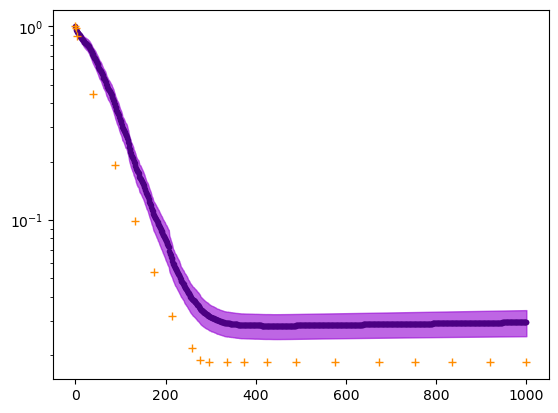

In [809]:
plt.plot(common_time, MI_sim_means, '.', color='indigo')
plt.fill_between(common_time, MI_sim_means, MI_sim_lower, alpha=0.6, color='darkviolet')
plt.fill_between(common_time, MI_sim_means, MI_sim_higher, alpha=0.6, color='darkviolet')
plt.plot(analytic_time, analytic_MI, '+', color='darkorange')
plt.yscale('log')

plt.savefig('/home/sagar/modeling-info-spread/reports/figures/mutual-info-pairs-over-time-wsim-binsym.pdf')

plt.show()

In [ ]:
# now do this for bin asym

In [805]:
MI_sim_runs = []
analytic_MI = []

analytical_time = None

num_runs = 100

X = [1/2, 1/2]

for channel in [bin_asym_channel(0.1, (0.1 - err) % 1)]:
    
    X1 = np.array([1, 0])
    X2 = np.array([0, 1])
    
    #E = single_flip_channel(1, 0.1)
    #    
    #initial_state_x1 = E @ X1
    #initial_state_x2 = E @ X2
    
    # Perfect Encoding
    initial_state_x1 = X1
    initial_state_x2 = X2

    # Noisy Gillespie Algorithm
    runs_x1 = list()
    for _ in tqdm(range(num_runs)):

        sim_x1 = NoisyGillespie(N=N, initial_state=initial_state_x1, beta=beta, k=k, 
                            channel=channel)
        test_sim = sim_x1.simulate(max_time=T, density=True)
        runs_x1.append((test_sim[0], test_sim[1]))
        
    runs_x2 = list()
    for _ in tqdm(range(num_runs)):

        sim_x2 = NoisyGillespie(N=N, initial_state=initial_state_x2, beta=beta, k=k, 
                            channel=channel)
        test_sim = sim_x2.simulate(max_time=T, density=True)
        runs_x2.append((test_sim[0], test_sim[1]))

    # Interpolating Gillespie Means
    common_time = np.linspace(0, T, T+1)
    interpolated_values_x1 = []
    interpolated_values_x2 = []

    for run_t, run_y in runs_x1:
        interp_func = interp1d(run_t, run_y, kind='linear', fill_value='extrapolate', axis=0) 
        interpolated_values_x1.append(interp_func(common_time))
    for run_t, run_y in runs_x2:
        interp_func = interp1d(run_t, run_y, kind='linear', fill_value='extrapolate', axis=0) 
        interpolated_values_x2.append(interp_func(common_time))

    interp_sim_arr_x1 = np.array(interpolated_values_x1)
    interp_sim_arr_x2 = np.array(interpolated_values_x2)

    for arr1, arr2 in tqdm(zip(interp_sim_arr_x1, interp_sim_arr_x2)):
        MI_run = []
        for t in range(arr1.shape[0]):
            sim_phi_x1 = arr1[t]/np.sum(arr1[t])
            sim_phi_x2 = arr2[t]/np.sum(arr2[t])
            
            MI_run.append(mutual_info(np.stack([sim_phi_x1, sim_phi_x2]), X))
        MI_sim_runs.append(MI_run)
        
    # Mean Field    
    mean_field = ODE(beta=beta, k=k, channel=channel, T=T)
    analytic_curve_x1 = mean_field(initial_state=initial_state_x1/N)
    analytic_curve_x2 = mean_field(initial_state=initial_state_x2/N)

    M1 = analytic_curve_x1.y.T
    M2 = analytic_curve_x2.y.T
    
    analytical_time = analytic_curve_x1.t
    
    for t in range(M1.shape[0]):
        phi_t_x1 = M1[t]/np.sum(M1[t])
        phi_t_x2 = M2[t]/np.sum(M2[t])
        
        analytic_MI.append(mutual_info(np.stack([phi_t_x1, phi_t_x2]), X))
        
    MI_se = np.std(np.array(MI_sim_runs), axis=0) / np.sqrt(num_runs)
    MI_conf_int = 1.96 * MI_se
    
    MI_sim_means = np.mean(np.array(MI_sim_runs), axis=0)
    
    MI_sim_lower = MI_sim_means - MI_conf_int
    MI_sim_higher = MI_sim_means + MI_conf_int

    MI_sim_lower = np.clip(MI_sim_lower, 0, 1)
    MI_sim_higher = np.clip(MI_sim_higher, 0, 1)
       
    #sim_se = np.std(interp_sim_arr, axis=0) / np.sqrt(num_runs)
    #conf_int = 1.96 * sim_se

    #sim_lower = sim_means - conf_int
    #sim_higher = sim_means + conf_int

    #sim_lower = np.clip(sim_lower, 0, 1)
    #sim_higher = np.clip(sim_higher, 0, 1)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

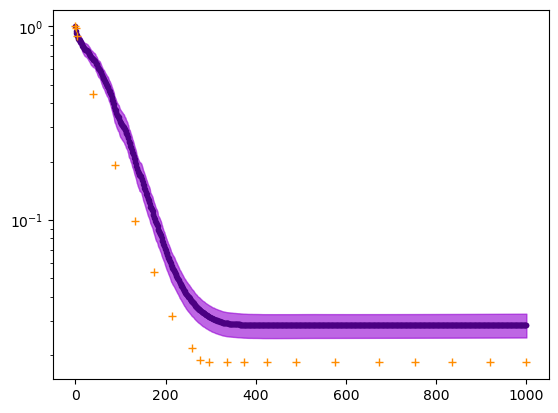

In [807]:
plt.plot(common_time, MI_sim_means, '.', color='indigo')
plt.fill_between(common_time, MI_sim_means, MI_sim_lower, alpha=0.6, color='darkviolet')
plt.fill_between(common_time, MI_sim_means, MI_sim_higher, alpha=0.6, color='darkviolet')
plt.plot(analytic_time, analytic_MI, '+', color='darkorange')
plt.yscale('log')

plt.savefig('/home/sagar/modeling-info-spread/reports/figures/mutual-info-pairs-over-time-wsim-binasym.pdf')

plt.show()

## TEST

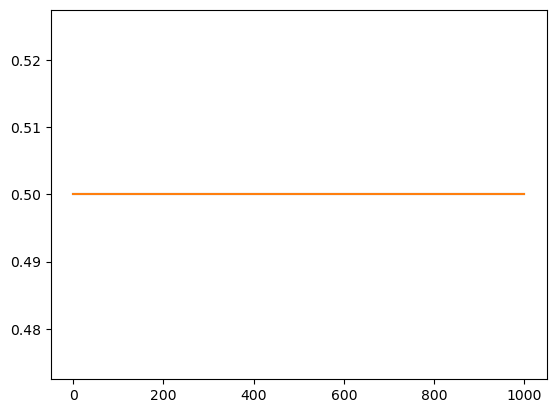

In [796]:

test_channel = single_flip_channel(1, 0.5)
test_mean_field = ODE(beta=beta, k=k, channel=test_channel, T=T)
test_analytic_curve = mean_field(initial_state=np.array([0.5,0.5])/N)

plt.plot(test_analytic_curve.t, [i/np.sum(i) for i in test_analytic_curve.y.T])

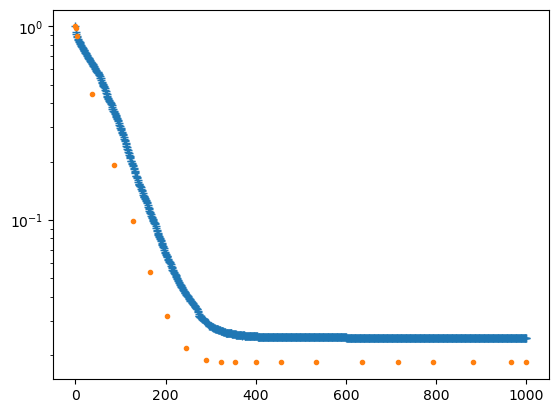

In [803]:
plt.plot(range(1001), MI_sim_means, '+')
plt.plot(analytical_time, analytic_MI, '.')
plt.yscale('log')

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0it [00:00, ?it/s]

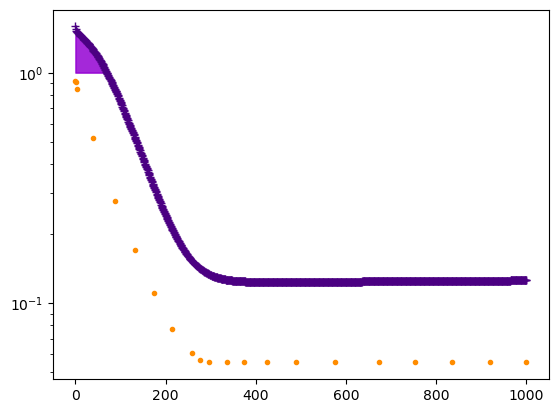

In [702]:
MI_sim_runs = []
analytic_MI = []

analytical_time = None

num_runs = 1000

X = [1/3,1/3,1/3]

for channel in [simplex_channel(3, 0.1)]:
    
    X1 = np.array([1, 0, 0])
    X2 = np.array([0, 1, 0])
    X3 = np.array([0, 0, 1])
    
    #E = simplex_channel(3, 0.1)
    #    
    #initial_state_x1 = E @ X1
    #initial_state_x2 = E @ X2
    #initial_state_x3 = E @ X3
    
    # Perfect Encoding
    initial_state_x1 = X1
    initial_state_x2 = X2
    initial_state_x3 = X3
    

    # Noisy Gillespie Algorithm
    runs_x1 = list()
    for _ in tqdm(range(num_runs)):

        sim_x1 = NoisyGillespie(N=N, initial_state=initial_state_x1, beta=beta, k=k, 
                            channel=channel)
        test_sim = sim_x1.simulate(max_time=T, density=True)
        runs_x1.append((test_sim[0], test_sim[1]))
        
    runs_x2 = list()
    for _ in tqdm(range(num_runs)):

        sim_x2 = NoisyGillespie(N=N, initial_state=initial_state_x2, beta=beta, k=k, 
                            channel=channel)
        test_sim = sim_x2.simulate(max_time=T, density=True)
        runs_x2.append((test_sim[0], test_sim[1]))
        
    runs_x3 = list()
    for _ in tqdm(range(num_runs)):

        sim_x3 = NoisyGillespie(N=N, initial_state=initial_state_x3, beta=beta, k=k, 
                            channel=channel)
        test_sim = sim_x3.simulate(max_time=T, density=True)
        runs_x3.append((test_sim[0], test_sim[1]))

    # Interpolating Gillespie Means
    common_time = np.linspace(0, T, T+1)
    interpolated_values_x1 = []
    interpolated_values_x2 = []
    interpolated_values_x3 = []

    for run_t, run_y in runs_x1:
        interp_func = interp1d(run_t, run_y, kind='linear', fill_value='extrapolate', axis=0) 
        interpolated_values_x1.append(interp_func(common_time))
    for run_t, run_y in runs_x2:
        interp_func = interp1d(run_t, run_y, kind='linear', fill_value='extrapolate', axis=0) 
        interpolated_values_x2.append(interp_func(common_time))
    for run_t, run_y in runs_x3:
        interp_func = interp1d(run_t, run_y, kind='linear', fill_value='extrapolate', axis=0) 
        interpolated_values_x3.append(interp_func(common_time))

    interp_sim_arr_x1 = np.array(interpolated_values_x1)
    interp_sim_arr_x2 = np.array(interpolated_values_x2)
    interp_sim_arr_x3 = np.array(interpolated_values_x3)

    for arr1, arr2, arr3 in tqdm(zip(interp_sim_arr_x1, interp_sim_arr_x2, interp_sim_arr_x3)):
        MI_run = []
        for t in range(arr1.shape[0]):
            sim_phi_x1 = arr1[t]/np.sum(arr1[t])
            sim_phi_x2 = arr2[t]/np.sum(arr2[t])
            sim_phi_x3 = arr3[t]/np.sum(arr3[t])
            
            MI_run.append(mutual_info(np.stack([sim_phi_x1, sim_phi_x2, sim_phi_x3]), X))
        MI_sim_runs.append(MI_run)
        
    # Mean Field    
    mean_field = ODE(beta=beta, k=k, channel=channel, T=T)
    analytic_curve_x1 = mean_field(initial_state=initial_state_x1/N)
    analytic_curve_x2 = mean_field(initial_state=initial_state_x2/N)
    analytic_curve_x3 = mean_field(initial_state=initial_state_x3/N)

    M1 = analytic_curve_x1.y.T
    M2 = analytic_curve_x2.y.T
    M3 = analytic_curve_x3.y.T
    
    analytical_time = analytic_curve_x1.t
    
    for t in range(M1.shape[0]):
        phi_t_x1 = M1[t]/np.sum(M1[t])
        phi_t_x2 = M2[t]/np.sum(M2[t])
        phi_t_x3 = M2[t]/np.sum(M3[t])
        
        analytic_MI.append(mutual_info(np.stack([phi_t_x1, phi_t_x2, phi_t_x3]), X))
        
    MI_se = np.std(np.array(MI_sim_runs), axis=0) / np.sqrt(num_runs)
    MI_conf_int = 1.96 * MI_se
    
    MI_sim_means = np.mean(np.array(MI_sim_runs), axis=0)
    
    MI_sim_lower = MI_sim_means - MI_conf_int
    MI_sim_higher = MI_sim_means + MI_conf_int

    MI_sim_lower = np.clip(MI_sim_lower, 0, 1)
    MI_sim_higher = np.clip(MI_sim_higher, 0, 1)
    
    plt.plot(common_time, MI_sim_means, '+', color='indigo')
    plt.fill_between(common_time, MI_sim_means, MI_sim_lower, alpha=0.6, color='darkviolet')
    plt.fill_between(common_time, MI_sim_means, MI_sim_higher, alpha=0.6, color='darkviolet')
    plt.plot(analytic_time, analytic_MI, '.', color='darkorange')
    plt.yscale('log')

    plt.savefig('/home/sagar/modeling-info-spread/reports/figures/mutual-info-triangle-over-time-wsim.pdf')

    plt.show()

In [ ]:
resolution = 100
channel = single_flip_channel(1, 0.001)

X1 = np.array([1, 0])
X2 = np.array([0, 1])

MI_enc = []
MI_phi = []



for err in np.linspace(0, 1, resolution + 1):

    E = single_flip_channel(1, err)
    MI_enc.append(mutual_info(E, X))

    initial_state_x1 = E @ X1
    initial_state_x2 = E @ X2

    # Mean Field    
    mean_field_x1 = ODE(beta=beta, k=k, channel=channel, T=T)
    analytic_curve_x1 = mean_field(initial_state=initial_state_x1/N)
    analytic_curve_x2 = mean_field(initial_state=initial_state_x2/N)

    M1 = analytic_curve_x1.y.T
    M2 = analytic_curve_x2.y.T
    
    last_phi_x1 = M1[-1]/np.sum(M1[-1])
    last_phi_x2 = M2[-1]/np.sum(M2[-1])
    
    # for t in M1... MI_phi.apped
    
    MI_phi.append(mutual_info(np.stack([last_phi_x1, last_phi_x2]), X))